# Grid Australia gravity data using gradient-boosted equivalent sources

In [1]:
from pathlib import Path
import time
import pooch
import pyproj
import numpy as np
import pandas as pd
import xarray as xr
import boule as bl
import verde as vd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

from boost_and_layouts import (
    EQLHarmonicBoost,
    block_averaged_sources,
    combine_parameters,
    save_to_json,
)

In [2]:
results_dir = Path("..") / "results" / "australia"

## Download Australia gravity data

In [3]:
fname = pooch.retrieve(
    url="https://github.com/compgeolab/australia-gravity-data/releases/download/v1.0/australia-ground-gravity.nc",
    known_hash="sha256:50f2fa53c5dc2c66dd3358b8e50024d21074fcc77c96191c549a10a37075bc7e",
    downloader=pooch.HTTPDownloader(progressbar=True),
)

# Load the data with xarray
data = xr.load_dataset(fname)
data

<xarray.Dataset>
Dimensions:            (point: 1789824)
Coordinates:
    longitude          (point) float64 140.1 140.1 140.1 ... 136.0 136.0 136.1
    latitude           (point) float64 -31.56 -31.56 -31.59 ... -33.49 -33.5
    height             (point) float32 111.7 112.5 118.4 ... 101.2 100.9 144.1
Dimensions without coordinates: point
Data variables:
    gravity            (point) float32 9.794e+05 9.794e+05 ... 9.796e+05
    gravity_accuracy   (point) float32 0.05 0.05 0.05 0.05 ... 0.05 0.05 0.05
    height_error       (point) float32 1.0 1.0 1.0 1.0 1.0 ... 2.0 2.0 2.0 2.0
    reliability_index  (point) uint8 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1
Attributes:
    Conventions:  CF-1.8
    title:        Compilation of gravity ground surveys for Australia
    institution:  Commonwealth of Australia (Geoscience Australia)
    crs:          WGS84
    source:       Compiled from the collection by Wynne, P. 2018. NetCDF Grou...
    uuid:         d6e3c3a8-5a20-4d8b-afca-e55f754e4ce1
    license:      Creative Commons Attribution 4.0 International Licence
    references:   https://doi.org/10.26186/5c1987fa17078
    history:      2020-10-13T15:39:24+01:00 : Data with reliability index of ...

Keep only the gravity dataset

In [4]:
data = data.gravity.to_dataset()
data

<xarray.Dataset>
Dimensions:    (point: 1789824)
Coordinates:
    longitude  (point) float64 140.1 140.1 140.1 140.1 ... 136.0 136.0 136.1
    latitude   (point) float64 -31.56 -31.56 -31.59 ... -33.54 -33.49 -33.5
    height     (point) float32 111.7 112.5 118.4 117.4 ... 101.2 100.9 144.1
Dimensions without coordinates: point
Data variables:
    gravity    (point) float32 9.794e+05 9.794e+05 ... 9.796e+05 9.796e+05

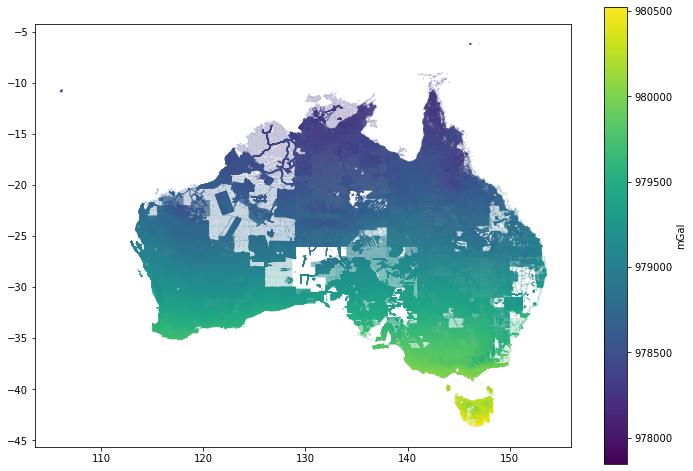

In [5]:
plt.figure(figsize=(12, 12))
tmp = plt.scatter(data.longitude, data.latitude, c=data.gravity, s=0.01)
plt.gca().set_aspect("equal")
plt.colorbar(tmp, label="mGal", shrink=0.7)
plt.show()

## Compute gravity disturbance

In [6]:
ell = bl.WGS84
disturbance = data.gravity - ell.normal_gravity(data.latitude, data.height)
data["disturbance"] = ("point", disturbance)
data

<xarray.Dataset>
Dimensions:      (point: 1789824)
Coordinates:
    longitude    (point) float64 140.1 140.1 140.1 140.1 ... 136.0 136.0 136.1
    latitude     (point) float64 -31.56 -31.56 -31.59 ... -33.54 -33.49 -33.5
    height       (point) float32 111.7 112.5 118.4 117.4 ... 101.2 100.9 144.1
Dimensions without coordinates: point
Data variables:
    gravity      (point) float32 9.794e+05 9.794e+05 ... 9.796e+05 9.796e+05
    disturbance  (point) float64 -4.502 -3.588 -3.967 ... -2.747 7.314 11.59

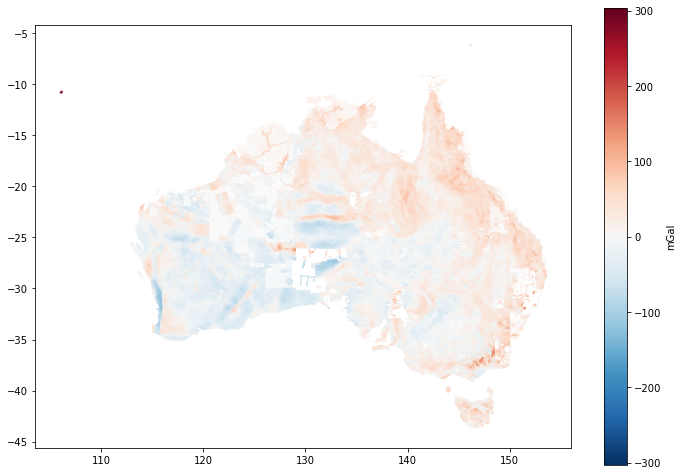

In [7]:
maxabs = vd.maxabs(data.disturbance)
plt.figure(figsize=(12, 12))
tmp = plt.scatter(
    data.longitude,
    data.latitude,
    c=data.disturbance,
    s=0.01,
    cmap="RdBu_r",
    vmin=-maxabs,
    vmax=maxabs,
)
plt.gca().set_aspect("equal")
plt.colorbar(tmp, label="mGal", shrink=0.7)
plt.show()

## Keep only points close to the continent

In [8]:
region = (112, 154, -44, -8)
inside = vd.inside(
    (data.longitude.values, data.latitude.values, data.height.values),
    region=region,
)

In [9]:
data = data.isel(point=inside)
data

<xarray.Dataset>
Dimensions:      (point: 1789755)
Coordinates:
    longitude    (point) float64 140.1 140.1 140.1 140.1 ... 136.0 136.0 136.1
    latitude     (point) float64 -31.56 -31.56 -31.59 ... -33.54 -33.49 -33.5
    height       (point) float32 111.7 112.5 118.4 117.4 ... 101.2 100.9 144.1
Dimensions without coordinates: point
Data variables:
    gravity      (point) float32 9.794e+05 9.794e+05 ... 9.796e+05 9.796e+05
    disturbance  (point) float64 -4.502 -3.588 -3.967 ... -2.747 7.314 11.59

In [10]:
vd.get_region(
    (data.longitude.values, data.latitude.values, data.height.values)
)

(112.934764, 153.61476, -43.735188, -9.008531999999999)

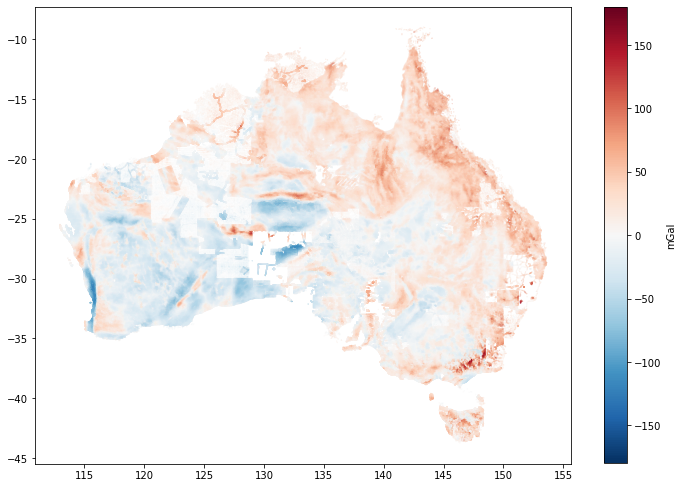

In [11]:
maxabs = vd.maxabs(data.disturbance)
plt.figure(figsize=(12, 12))
tmp = plt.scatter(
    data.longitude,
    data.latitude,
    c=data.disturbance,
    s=0.01,
    cmap="RdBu_r",
    vmin=-maxabs,
    vmax=maxabs,
)
plt.gca().set_aspect("equal")
plt.colorbar(tmp, label="mGal", shrink=0.7)
plt.show()

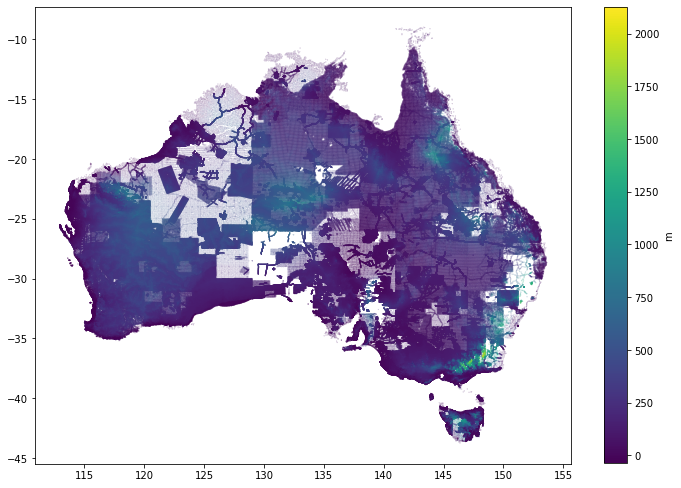

In [12]:
plt.figure(figsize=(12, 12))
tmp = plt.scatter(data.longitude, data.latitude, c=data.height, s=0.01)
plt.gca().set_aspect("equal")
plt.colorbar(tmp, label="m", shrink=0.7)
plt.show()

Plot histograms of data and observation heighs

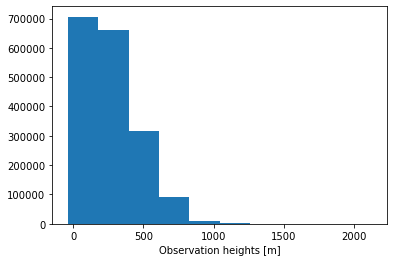

In [13]:
plt.hist(data.height)
plt.xlabel("Observation heights [m]")
plt.show()

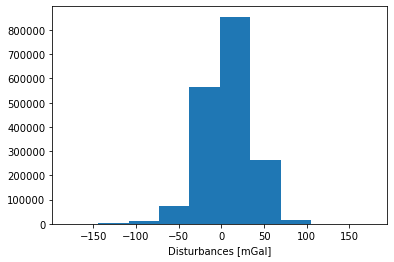

In [14]:
plt.hist(data.disturbance)
plt.xlabel("Disturbances [mGal]")
plt.show()

Save gravity disturbanceurbance points on a netCDF file to save disk space

In [15]:
data.to_netcdf(results_dir / "australia-data.nc")

## Project coordinates

In [16]:
projection = pyproj.Proj(proj="merc", lat_ts=data.latitude.values.mean())
easting, northing = projection(data.longitude.values, data.latitude.values)

In [17]:
data.coords["easting"] = ("point", easting)
data.coords["northing"] = ("point", northing)
data

<xarray.Dataset>
Dimensions:      (point: 1789755)
Coordinates:
    longitude    (point) float64 140.1 140.1 140.1 140.1 ... 136.0 136.0 136.1
    latitude     (point) float64 -31.56 -31.56 -31.59 ... -33.54 -33.49 -33.5
    height       (point) float32 111.7 112.5 118.4 117.4 ... 101.2 100.9 144.1
    easting      (point) float64 1.379e+07 1.379e+07 ... 1.339e+07 1.34e+07
    northing     (point) float64 -3.257e+06 -3.257e+06 ... -3.482e+06 -3.484e+06
Dimensions without coordinates: point
Data variables:
    gravity      (point) float32 9.794e+05 9.794e+05 ... 9.796e+05 9.796e+05
    disturbance  (point) float64 -4.502 -3.588 -3.967 ... -2.747 7.314 11.59

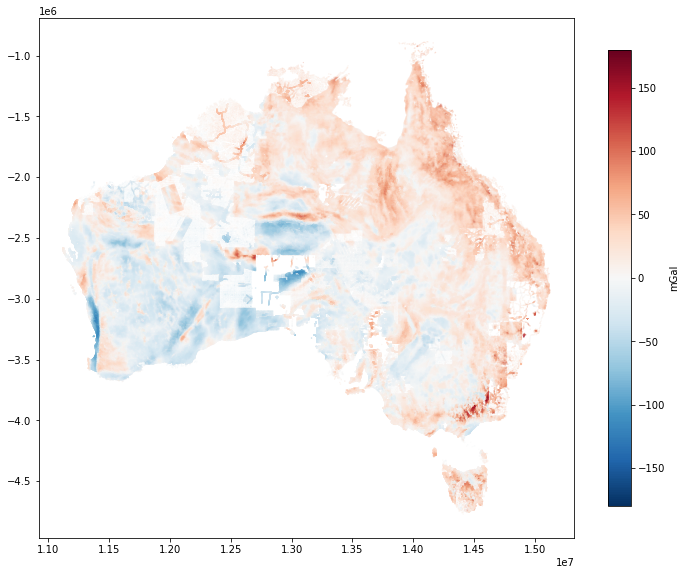

In [18]:
maxabs = vd.maxabs(data.disturbance)
plt.figure(figsize=(12, 12))
tmp = plt.scatter(
    data.easting,
    data.northing,
    c=data.disturbance,
    s=0.01,
    cmap="RdBu_r",
    vmin=-maxabs,
    vmax=maxabs,
)
plt.gca().set_aspect("equal")
plt.colorbar(tmp, label="mGal", shrink=0.7)
plt.show()

## Data density

Let's plot the density of the data points as number of points per kilometer square.

In [19]:
# Divide the region in blocks where the data density will be computed
spacing = 30e3
density_grid_coords = vd.grid_coordinates(
    region=vd.get_region((data.easting.values, data.northing.values)),
    spacing=spacing,
    pixel_register=True,
)

# Define the kdtree and get the labels for each data point
# Each label identifies a given data point with its corresponding block
tree = vd.utils.kdtree(density_grid_coords)
labels = tree.query(np.transpose((data.easting.values, data.northing.values)))[1]

# Get the total number of points inside each block
labels, counts = np.unique(labels, return_counts=True)

# Get the indices for each block
indices = [np.unravel_index(i, density_grid_coords[0].shape) for i in labels]

# Generate a data density grid
data_density = np.nan * np.ones_like(density_grid_coords[0])
for index, count in zip(indices, counts):
    data_density[index] = count
    
# Check if the total number of data points coincides with the total count
assert np.nansum(data_density) == data.easting.values.size

# Divide the count with the area of each block
data_density /= (spacing * 1e-3) ** 2 

# Generate a data density grid
density_grid = vd.make_xarray_grid(
    density_grid_coords, data_density, data_names=["data_density"]
).data_density
density_grid.attrs = {"units": "n_data/km^2"}
density_grid

<xarray.DataArray 'data_density' (northing: 130, easting: 134)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * easting   (easting) float64 1.113e+07 1.116e+07 ... 1.508e+07 1.511e+07
  * northing  (northing) float64 -4.757e+06 -4.727e+06 ... -9.295e+05 -8.997e+05
Attributes:
    units:    n_data/km^2

(array([8.534e+03, 1.860e+02, 5.100e+01, 1.600e+01, 1.300e+01, 4.000e+00,
        5.000e+00, 2.000e+00, 2.000e+00, 3.000e+00]),
 array([1.11111111e-03, 1.01155556e+00, 2.02200000e+00, 3.03244444e+00,
        4.04288889e+00, 5.05333333e+00, 6.06377778e+00, 7.07422222e+00,
        8.08466667e+00, 9.09511111e+00, 1.01055556e+01]),
 <BarContainer object of 10 artists>)

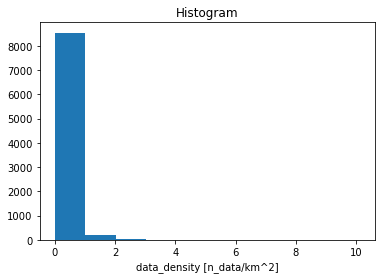

In [20]:
density_grid.plot.hist()

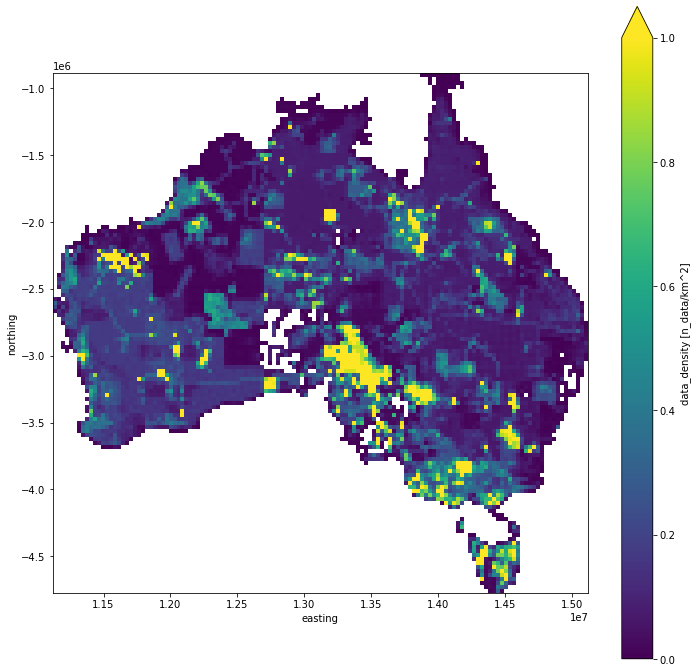

In [21]:
plt.figure(figsize=(12, 12))
density_grid.plot(vmin=0, vmax=1)
plt.gca().set_aspect("equal")
plt.show()

In [22]:
density_grid.to_netcdf(results_dir / "australia-density-data.nc")

## Estimate window size for gradient boosting

We will choose the spacing for the block-averaged sources equal to the spacing for the ultimate grid.
The final grid will have a spacing of 1 arc-minute, which can be approximated by ~1.8km.

In [23]:
ell.mean_radius * np.radians(1 / 60)

1853.2513289105264

In [24]:
spacing = 1800.0

Estimate the window size for gradient boosting

In [25]:
window_sizes = np.arange(50e3, 350e3, 25e3)

# Create sources with the spacing obtained before
coordinates = (data.easting.values, data.northing.values, data.height.values)
sources = block_averaged_sources(
    coordinates,
    spacing=spacing,
    depth_type="relative_depth",
    depth=0.
)

memory_gb = []
for window_size in window_sizes:
    eql = EQLHarmonicBoost(window_size=window_size)
    eql.points_ = sources
    source_windows, data_windows = eql._create_rolling_windows(coordinates)
    # Get the size of each source and data windows
    source_sizes = np.array([w.size for w in source_windows])
    data_sizes = np.array([w.size for w in data_windows])
    # Compute the size of the Jacobian matrix for each window
    jacobian_sizes = source_sizes * data_sizes
    # Register the amount of memory to store the Jacobian matrix (double precision)
    memory_gb.append(jacobian_sizes.max() * (64 / 8) / 1024 ** 3)

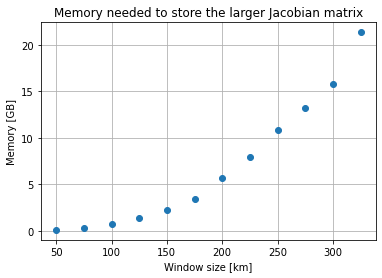

In [26]:
plt.plot(window_sizes * 1e-3, memory_gb, "o")
plt.xlabel("Window size [km]")
plt.ylabel("Memory [GB]")
plt.title("Memory needed to store the larger Jacobian matrix")
plt.grid()
plt.show()

Choose a window size of 250km so we use around of ~10GB of RAM.

In [27]:
window_size = 225e3

Save results in a CSV file

In [28]:
pd.DataFrame({"window_size": window_sizes, "memory_gb": memory_gb}).to_csv(
    results_dir / "australia-window-size-vs-memory-need.csv"
)

## Cross-validate gridder for estimating parameters

Choose only a portion of the data to apply CV to speed up things

In [29]:
easting_0, northing_0 = 14053825.0, -3451038.0
easting_size, northing_size = 300e3, 300e3
smaller_region = (
    easting_0,
    easting_0 + easting_size,
    northing_0,
    northing_0 + northing_size,
)

inside = vd.inside(
    (data.easting.values, data.northing.values),
    region=smaller_region,
)
small_data = data.isel(point=inside)
small_data

<xarray.Dataset>
Dimensions:      (point: 14934)
Coordinates:
    longitude    (point) float64 145.8 145.7 145.6 145.6 ... 143.8 143.9 143.1
    latitude     (point) float64 -31.47 -31.48 -31.48 ... -30.96 -30.83 -31.43
    height       (point) float32 246.0 240.0 239.4 231.3 ... 123.7 97.4 99.29
    easting      (point) float64 1.435e+07 1.435e+07 ... 1.416e+07 1.409e+07
    northing     (point) float64 -3.247e+06 -3.249e+06 ... -3.174e+06 -3.242e+06
Dimensions without coordinates: point
Data variables:
    gravity      (point) float32 9.794e+05 9.794e+05 ... 9.794e+05 9.794e+05
    disturbance  (point) float64 16.46 15.67 17.87 17.29 ... 1.131 -9.686 -22.94

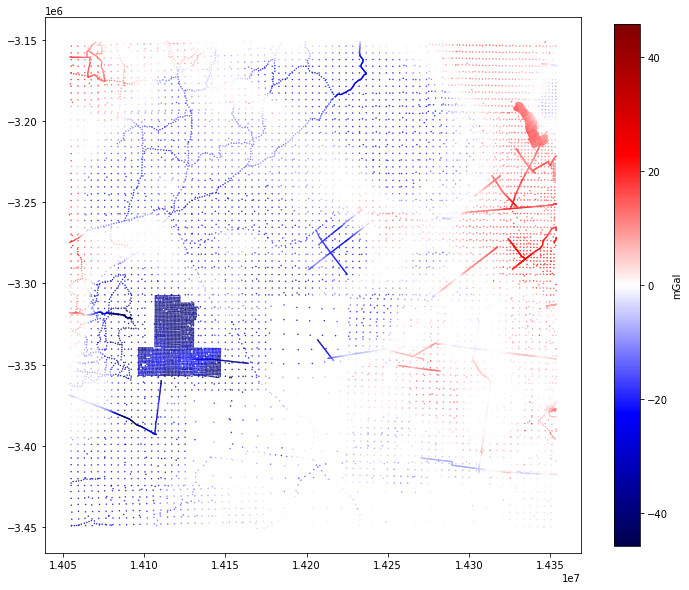

In [30]:
plt.figure(figsize=(12, 12))
maxabs = vd.maxabs(small_data.disturbance)
tmp = plt.scatter(
    small_data.easting,
    small_data.northing,
    c=small_data.disturbance,
    s=0.2,
    vmin=-maxabs,
    vmax=maxabs,
    cmap="seismic"
)
plt.gca().set_aspect("equal")
plt.colorbar(tmp, label="mGal", shrink=0.8)
plt.show()

Define parameters space

In [31]:
depth_type = "relative_depth"
random_state = 0
dampings = np.logspace(-2, 4, 7)
depths = np.linspace(1e3, 15e3, 15)

# Combine these parameters
parameter_sets = combine_parameters(
    **dict(
        depth_type=depth_type,
        depth=depths,
        damping=dampings,
        spacing=spacing,
        window_size=window_size,
        random_state=random_state,
    )
)
print("Number of combinations:", len(parameter_sets))

Number of combinations: 105


Apply cross validation

In [32]:
%%time
cv = KFold(n_splits=6, shuffle=True, random_state=0)

coordinates = (
    small_data.easting.values,
    small_data.northing.values,
    small_data.height.values,
)
disturbance = small_data.disturbance.values

# Apply CV for each set of parameters
scores, scores_std = [], []
for parameters in parameter_sets:
    # Define EQL with custom sources
    points = block_averaged_sources(coordinates, **parameters)
    eql = EQLHarmonicBoost(
        points=points,
        damping=parameters["damping"],
        window_size=parameters["window_size"],
        random_state=parameters["random_state"],
    )
    
    # Score the interpolation (and track computation time)
    start = time.time()
    scores_i = vd.cross_val_score(
        eql,
        coordinates,
        disturbance,
        cv=cv,
        scoring="neg_root_mean_squared_error",
    )
    end = time.time()
    score = np.mean(-scores_i) # compute RMS by placing a minus
    score_std = np.std(-scores_i)
    print(
        "Last CV took: {:.0f}s. RMS: {:.3f}. RMSs std: {:.6f}".format(
            end - start, score, score_std
        )
    )
    scores.append(score)
    scores_std.append(score_std)

Last CV took: 45s. RMS: 101.183. RMSs std: 9.017012
Last CV took: 42s. RMS: 36.530. RMSs std: 2.088662
Last CV took: 42s. RMS: 11.821. RMSs std: 0.840699
Last CV took: 42s. RMS: 3.647. RMSs std: 0.283897
Last CV took: 42s. RMS: 1.605. RMSs std: 0.110650
Last CV took: 42s. RMS: 1.440. RMSs std: 0.064127
Last CV took: 43s. RMS: 1.695. RMSs std: 0.042479
Last CV took: 42s. RMS: 33.885. RMSs std: 4.380247
Last CV took: 43s. RMS: 11.233. RMSs std: 1.612033
Last CV took: 43s. RMS: 3.773. RMSs std: 0.384938
Last CV took: 43s. RMS: 1.742. RMSs std: 0.161620
Last CV took: 43s. RMS: 1.370. RMSs std: 0.089249
Last CV took: 43s. RMS: 1.370. RMSs std: 0.063658
Last CV took: 43s. RMS: 1.781. RMSs std: 0.047692
Last CV took: 43s. RMS: 15.266. RMSs std: 3.851956
Last CV took: 42s. RMS: 5.133. RMSs std: 0.663559
Last CV took: 43s. RMS: 2.211. RMSs std: 0.189477
Last CV took: 42s. RMS: 1.504. RMSs std: 0.110678
Last CV took: 42s. RMS: 1.346. RMSs std: 0.079750
Last CV took: 42s. RMS: 1.420. RMSs std: 0.

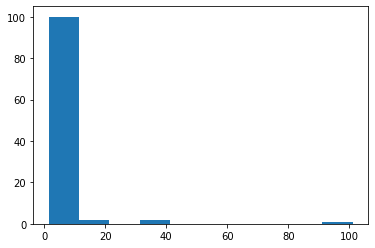

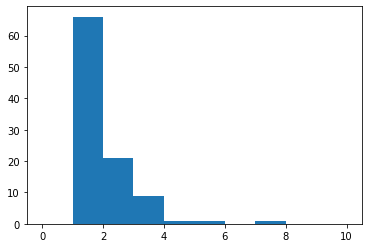

In [33]:
plt.hist(scores)
plt.show()

plt.hist(scores, range=(0, 10))
plt.show()

In [34]:
best_score = np.min(scores)
best_parameters = parameter_sets[np.argmin(scores)]

print(best_score)
print(best_parameters)

1.345739462602289
{'depth_type': 'relative_depth', 'depth': 3000.0, 'damping': 100.0, 'spacing': 1800.0, 'window_size': 225000.0, 'random_state': 0}


In [35]:
scores_array = np.array(scores).reshape((dampings.size, depths.size), order="F")
scores_2d = xr.DataArray(
    scores_array,
    dims=("damping", "depth"),
    coords={"depth": depths, "damping": dampings}
)
scores_2d

<xarray.DataArray (damping: 7, depth: 15)>
array([[101.18349591,  33.88529695,  15.26635308,   7.90096327,
          4.7779086 ,   3.39963351,   2.95212767,   2.54722177,
          2.2427257 ,   2.06126064,   1.94498022,   1.85609077,
          1.79920779,   1.74930291,   1.7279287 ],
       [ 36.52955196,  11.23283844,   5.13273288,   3.05635225,
          2.35166624,   2.04682944,   1.81897101,   1.69030746,
          1.63442826,   1.59970583,   1.57326081,   1.55788296,
          1.56815566,   1.60064876,   1.64485257],
       [ 11.82128926,   3.77329684,   2.21099352,   1.8044711 ,
          1.6198248 ,   1.51448167,   1.47249871,   1.45911619,
          1.45706057,   1.46895986,   1.49705402,   1.53570846,
          1.58155847,   1.63334164,   1.69094074],
       [  3.64680563,   1.74214304,   1.50429782,   1.4257572 ,
          1.38810349,   1.38391769,   1.39856584,   1.42826091,
          1.470894  ,   1.52348736,   1.58386687,   1.64915205,
          1.71679171,   1.7845887 ,   1.84978805],
       [  1.60485979,   1.37013216,   1.34573946,   1.34874646,
          1.37924751,   1.42831859,   1.49003214,   1.55864844,
          1.62959992,   1.7005371 ,   1.77106995,   1.84198701,
          1.91452946,   1.98994592,   2.06945018],
       [  1.44024458,   1.36976839,   1.42047596,   1.50018196,
          1.59139868,   1.6861587 ,   1.78250074,   1.88069577,
          1.98149282,   2.08589336,   2.19474621,   2.30778657,
          2.42324838,   2.53847242,   2.65099912],
       [  1.69538005,   1.78149114,   1.92466533,   2.06856033,
          2.2130517 ,   2.35821331,   2.50322846,   2.64636508,
          2.78570158,   2.91990194,   3.04849571,   3.17173871,
          3.29033968,   3.40522164,   3.51733844]])
Coordinates:
  * depth    (depth) float64 1e+03 2e+03 3e+03 4e+03 ... 1.3e+04 1.4e+04 1.5e+04
  * damping  (damping) float64 0.01 0.1 1.0 10.0 100.0 1e+03 1e+04

In [36]:
scores_2d.to_netcdf(results_dir / "australia-scores.nc")

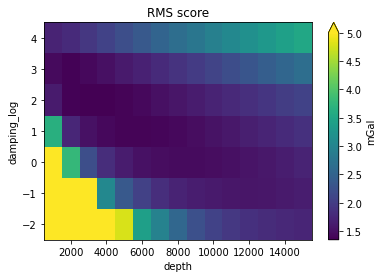

In [37]:
# Plot the scores_2d grid with the damping log as y axis
scores_2d.coords["damping_log"] = ("damping", np.log10(scores_2d.damping))

scores_2d.plot(y="damping_log", vmax=5, cbar_kwargs={"label": "mGal"})
plt.title("RMS score")
plt.show()

## Use the subset for gridding on this subregion

In [38]:
coordinates = (
    small_data.easting.values,
    small_data.northing.values,
    small_data.height.values,
)
points = block_averaged_sources(coordinates, **best_parameters)

In [39]:
%%time
eql = EQLHarmonicBoost(
    points=points,
    damping=best_parameters["damping"],
    window_size=best_parameters["window_size"],
    random_state=best_parameters["random_state"],
)
eql.fit(coordinates, small_data.disturbance.values)

CPU times: user 31.9 s, sys: 23.4 s, total: 55.3 s
Wall time: 8.01 s


EQLHarmonicBoost(damping=100.0,
                 points=(array([14055203.07746712, 14056975.27193933, 14068062.41592319, ...,
       14277760.67432543, 14283514.3990452 , 14346958.07505294]),
                         array([-3449258.63164093, -3449164.81567405, -3449139.40001199, ...,
       -3152712.80157355, -3152048.98018384, -3151343.5292146 ]),
                         array([-2930.306, -2929.677, -2917.349, ..., -2886.496, -2883.82 ,
       -2731.779], dtype=float32)),
                 random_state=0, window_size=225000.0)

In [40]:
%%time
# Interpolate on a regular grid
grid = eql.grid(
    upward=small_data.height.values.max(),
    spacing=spacing,
    data_names=["disturbance"],
)

CPU times: user 1.59 s, sys: 7.51 ms, total: 1.6 s
Wall time: 653 ms


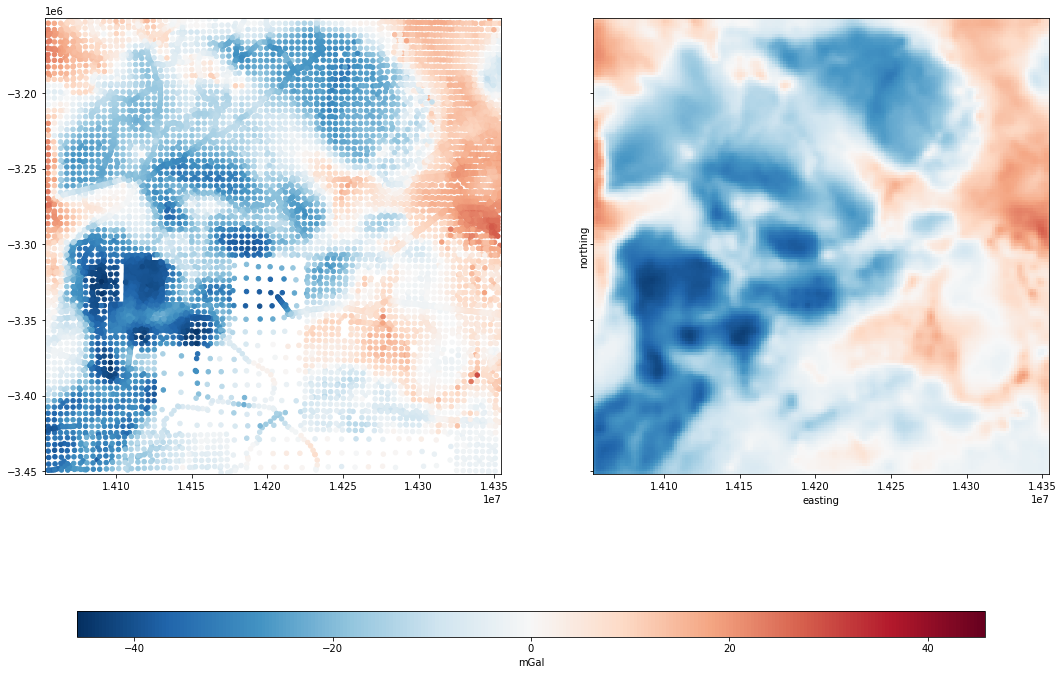

In [41]:
maxabs = vd.maxabs(grid.disturbance, small_data.disturbance)

fig, (ax1, ax2) = plt.subplots(
    nrows=1, ncols=2, figsize=(18, 12), sharex=True, sharey=True
)
tmp = ax1.scatter(
    small_data.easting.values,
    small_data.northing.values,
    c=small_data.disturbance,
    s=20,
    vmin=-maxabs,
    vmax=maxabs,
    cmap="RdBu_r"
)
grid.disturbance.plot(
    ax=ax2, add_colorbar=False, vmin=-maxabs, vmax=maxabs, cmap="RdBu_r"
)
for ax in (ax1, ax2):
    ax.set_aspect("equal")

cbar_ax = fig.add_axes([0.15, 0.05, 0.7, 0.03])
fig.colorbar(tmp, cax=cbar_ax, orientation="horizontal", label="mGal")

plt.show()

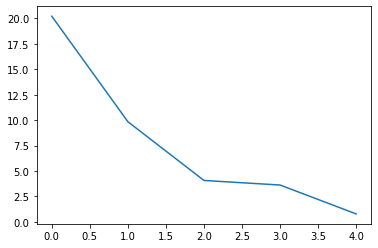

In [42]:
plt.plot(eql.errors_)
plt.show()

Compute residuals

In [43]:
residuals = small_data.disturbance - eql.predict(coordinates)

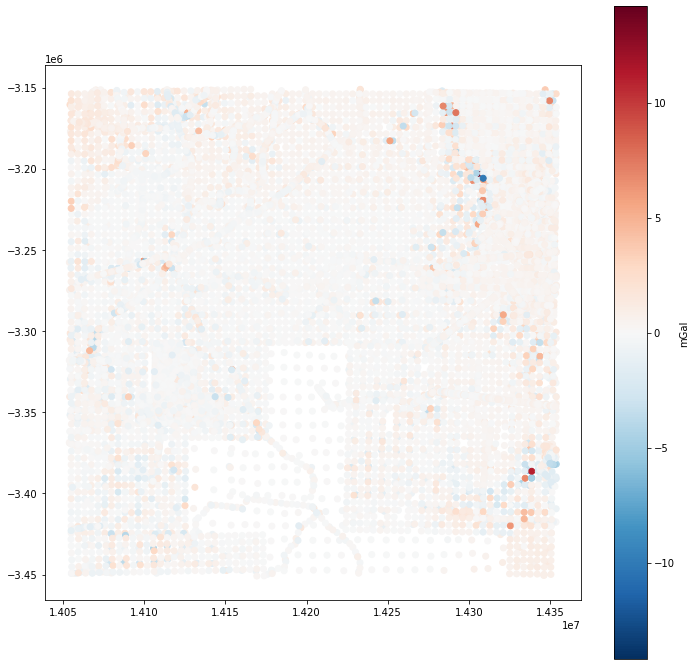

In [44]:
maxabs = vd.maxabs(residuals)
plt.figure(figsize=(12, 12))
tmp = plt.scatter(
    small_data.easting.values,
    small_data.northing.values,
    c=residuals,
    vmin=-maxabs,
    vmax=maxabs,
    cmap="RdBu_r",
)
plt.gca().set_aspect("equal")
plt.colorbar(tmp, label="mGal")
plt.show()

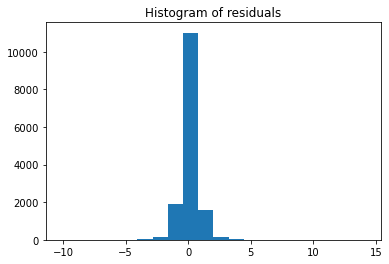

In [45]:
plt.hist(residuals, bins=20)
plt.title("Histogram of residuals")
plt.show()

## Grid gravity disturbance

In [46]:
coordinates = (
    data.easting.values,
    data.northing.values,
    data.height.values,
)
points = block_averaged_sources(coordinates, **best_parameters)

In [47]:
memory_gb = coordinates[0].size * points[0].size * (64 / 8) / 1024 ** 3

print("Number of data points:", coordinates[0].size)
print("Number of sources:", points[0].size)
print("Memory needed to store the full Jacobian matrix: {:.2f} GB".format(memory_gb))

Number of data points: 1789755
Number of sources: 796744
Memory needed to store the full Jacobian matrix: 10624.35 GB


In [48]:
%%time
eql = EQLHarmonicBoost(
    points=points,
    damping=best_parameters["damping"],
    window_size=best_parameters["window_size"],
    random_state=best_parameters["random_state"],
)
eql.fit(coordinates, data.disturbance.values)

CPU times: user 11h 56s, sys: 1h 37min 20s, total: 12h 38min 16s
Wall time: 1h 21min 5s


EQLHarmonicBoost(damping=100.0,
                 points=(array([14411034.42448726, 14401746.74707942, 14412150.02090752, ...,
       14090856.87350095, 14120393.15267198, 14113665.70554498]),
                         array([-4771548.94637836, -4759608.33762645, -4758523.73883176, ...,
        -890973.28814625,  -886847.04788876,  -884700.92055612]),
                         array([-3002.224, -2834.246, -2940.713, ..., -2919.176, -2920.13 ,
       -2919.548], dtype=float32)),
                 random_state=0, window_size=225000.0)

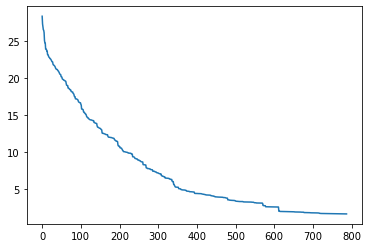

In [49]:
plt.plot(eql.errors_)
plt.show()

In [50]:
%%time
# Get region of longitude, latitude coordinates (in degrees)
region_deg = vd.get_region(
    (data.longitude.values, data.latitude.values)
)
# Interpolate on a regular grid on geographic coordinates
grid = eql.grid(
    upward=data.height.values.max(),
    region=region_deg,
    spacing=1 / 60,
    projection=projection,
    dims=("latitude", "longitude"),
    data_names=["disturbance"],
)

CPU times: user 4h 48min 32s, sys: 287 ms, total: 4h 48min 32s
Wall time: 18min 13s


In [51]:
grid

<xarray.Dataset>
Dimensions:      (latitude: 2085, longitude: 2442)
Coordinates:
  * longitude    (longitude) float64 112.9 113.0 113.0 ... 153.6 153.6 153.6
  * latitude     (latitude) float64 -43.74 -43.72 -43.7 ... -9.042 -9.025 -9.009
    upward       (latitude, longitude) float64 2.128e+03 2.128e+03 ... 2.128e+03
Data variables:
    disturbance  (latitude, longitude) float64 0.129 0.1283 ... 12.26 12.25
Attributes:
    metadata:  Generated by EQLHarmonicBoost(damping=100.0,\n                ...

In [52]:
grid_masked = vd.distance_mask(
    (data.longitude.values, data.latitude.values),
    grid=grid,
    maxdist=50e3,
    projection=projection,
)
grid_masked

<xarray.Dataset>
Dimensions:      (latitude: 2085, longitude: 2442)
Coordinates:
  * longitude    (longitude) float64 112.9 113.0 113.0 ... 153.6 153.6 153.6
  * latitude     (latitude) float64 -43.74 -43.72 -43.7 ... -9.042 -9.025 -9.009
    upward       (latitude, longitude) float64 2.128e+03 2.128e+03 ... 2.128e+03
Data variables:
    disturbance  (latitude, longitude) float64 nan nan nan nan ... nan nan nan
Attributes:
    metadata:  Generated by EQLHarmonicBoost(damping=100.0,\n                ...

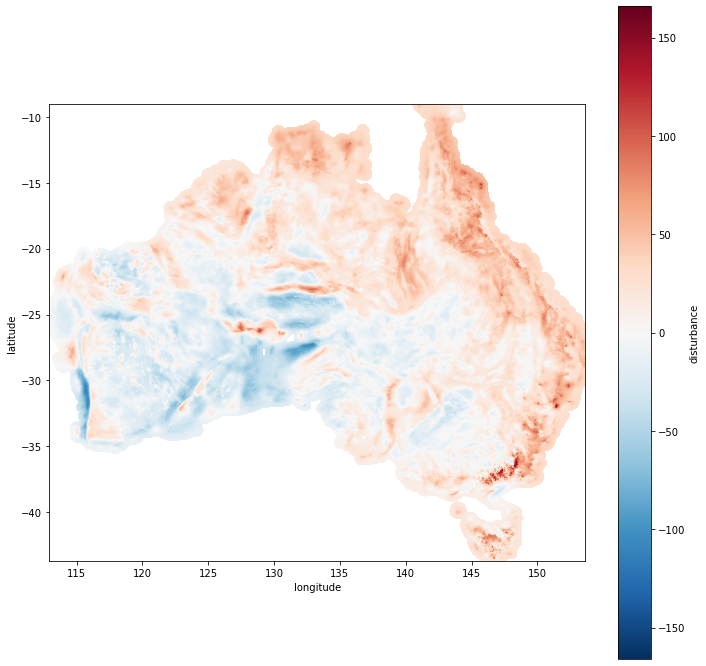

In [53]:
plt.figure(figsize=(12, 12))
grid_masked.disturbance.plot()
plt.gca().set_aspect("equal")
plt.show()

Plot both the grid and the original data on a zoomed region

In [54]:
region = (128, 135, -35, -25)

# Cut the masked grid into a zoomed region
subgrid = grid_masked.sel(longitude=slice(*region[:2]), latitude=slice(*region[2:]))

# Cut the data into a zoomed region
inside = vd.inside(
    (data.longitude.values, data.latitude.values),
    region,
)
data_zoom = data.isel(point=inside)

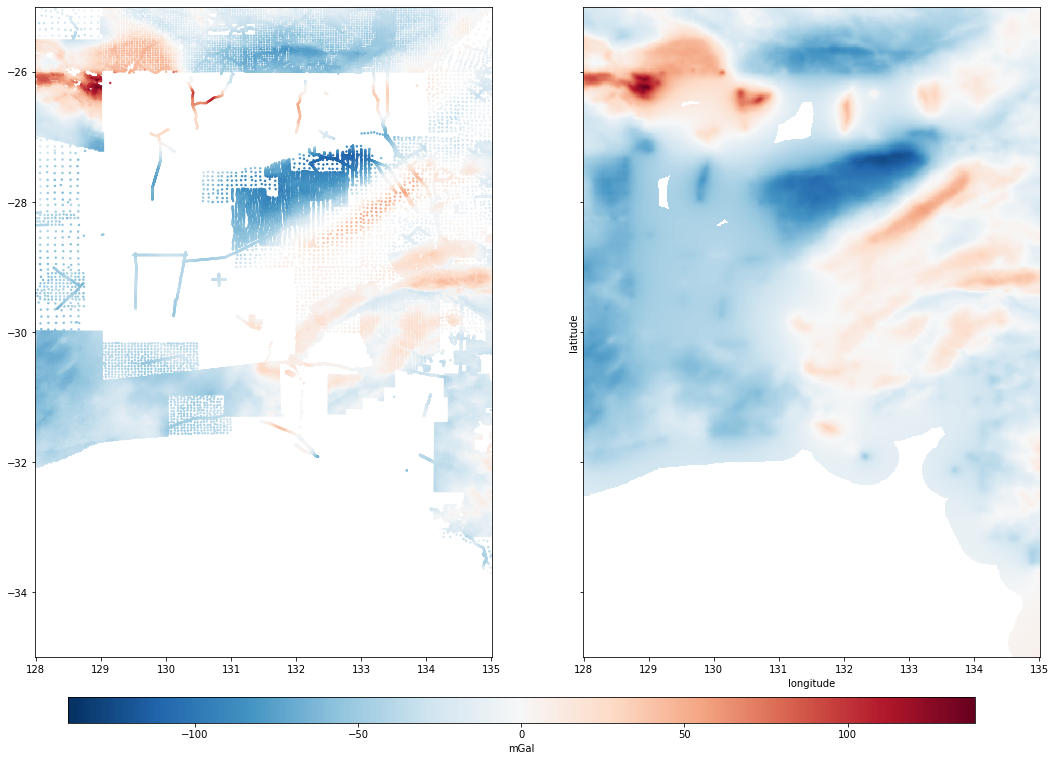

In [55]:
maxabs = vd.maxabs(subgrid.disturbance.values, data_zoom.disturbance)

fig, (ax1, ax2) = plt.subplots(
    nrows=1, ncols=2, figsize=(18, 12), sharey=True, sharex=True
)
tmp = ax1.scatter(
    data_zoom.longitude,
    data_zoom.latitude,
    c=data_zoom.disturbance,
    s=2,
    vmin=-maxabs,
    vmax=maxabs,
    cmap="RdBu_r"
)
subgrid.disturbance.plot(ax=ax2, add_colorbar=False)

for ax in (ax1, ax2):
    ax.set_aspect("equal")

cbar_ax = fig.add_axes([0.15, 0.05, 0.7, 0.03])
fig.colorbar(tmp, cax=cbar_ax, orientation="horizontal", label="mGal")

plt.show()

Compute residuals

In [56]:
coordinates = (data.easting.values, data.northing.values, data.height.values)
residuals = data.disturbance - eql.predict(coordinates)

In [57]:
data["eql_residuals"] = ("point", residuals)
data

<xarray.Dataset>
Dimensions:        (point: 1789755)
Coordinates:
    longitude      (point) float64 140.1 140.1 140.1 140.1 ... 136.0 136.0 136.1
    latitude       (point) float64 -31.56 -31.56 -31.59 ... -33.54 -33.49 -33.5
    height         (point) float32 111.7 112.5 118.4 117.4 ... 101.2 100.9 144.1
    easting        (point) float64 1.379e+07 1.379e+07 ... 1.339e+07 1.34e+07
    northing       (point) float64 -3.257e+06 -3.257e+06 ... -3.484e+06
Dimensions without coordinates: point
Data variables:
    gravity        (point) float32 9.794e+05 9.794e+05 ... 9.796e+05 9.796e+05
    disturbance    (point) float64 -4.502 -3.588 -3.967 ... -2.747 7.314 11.59
    eql_residuals  (point) float64 -0.1565 0.0952 -0.2814 ... -0.5962 1.377

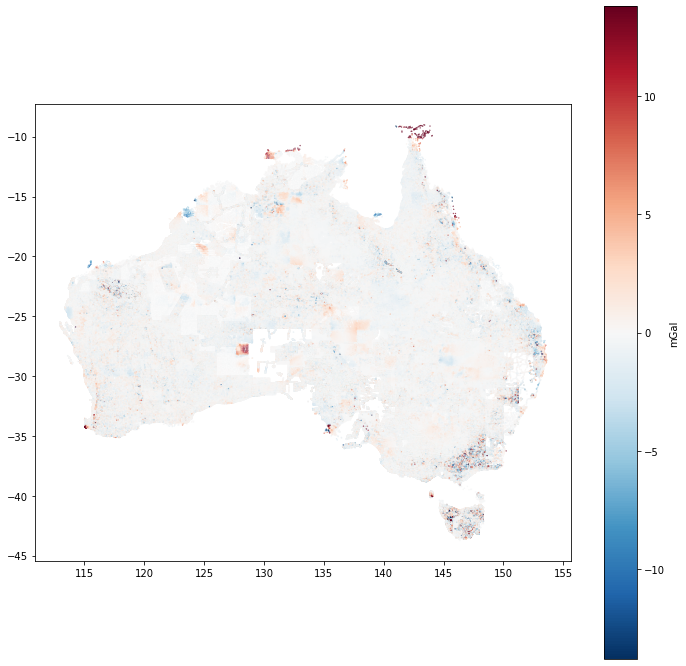

In [58]:
maxabs = vd.maxabs(residuals)
maxabs = np.quantile(residuals, q=0.999)
plt.figure(figsize=(12, 12))
tmp = plt.scatter(
    data.longitude,
    data.latitude,
    c=residuals,
    s=0.1,
    vmin=-maxabs,
    vmax=maxabs,
    cmap="RdBu_r",
)
plt.gca().set_aspect("equal")
plt.colorbar(tmp, label="mGal")
plt.show()

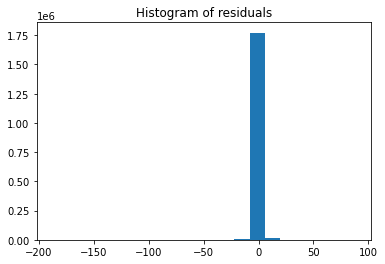

In [59]:
plt.hist(residuals, bins=20)
plt.title("Histogram of residuals")
plt.show()

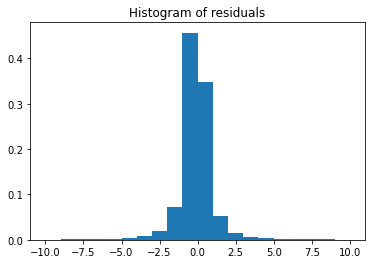

In [60]:
plt.hist(residuals, bins=20, range=(-10, 10), density=True)
plt.title("Histogram of residuals")
plt.show()

Save grid on a netCDF file. First transform some arrays into float32 to save disk space.

In [61]:
grid_masked["upward"] = (
    ("latitude", "longitude"),
    np.array(grid_masked.upward, dtype="float32"),
)
grid_masked["disturbance"] = (
    ("latitude", "longitude"),
    np.array(grid_masked.disturbance, dtype="float32"),
)

In [62]:
grid_masked

<xarray.Dataset>
Dimensions:      (latitude: 2085, longitude: 2442)
Coordinates:
  * longitude    (longitude) float64 112.9 113.0 113.0 ... 153.6 153.6 153.6
  * latitude     (latitude) float64 -43.74 -43.72 -43.7 ... -9.042 -9.025 -9.009
    upward       (latitude, longitude) float32 2.128e+03 2.128e+03 ... 2.128e+03
Data variables:
    disturbance  (latitude, longitude) float32 nan nan nan nan ... nan nan nan
Attributes:
    metadata:  Generated by EQLHarmonicBoost(damping=100.0,\n                ...

In [63]:
grid_masked.to_netcdf(results_dir / "australia-grid.nc")

Save parameters to a JSON file

In [64]:
variables = {
    "australia_eql_depth": best_parameters["depth"],
    "australia_eql_damping": best_parameters["damping"],
    "australia_eql_spacing": best_parameters["spacing"],
    "australia_eql_window_size": best_parameters["window_size"],
    "australia_eql_n_sources": points[0].size,
    "australia_eql_grid_n_longitude": grid_masked.longitude.size,
    "australia_eql_grid_n_latitude": grid_masked.latitude.size,
    "australia_eql_grid_height": grid_masked.upward.values.ravel()[0],
}

json_file = Path("..") / "results" / "australia.json"
save_to_json(variables, json_file)